# **Small Language Models (SLMs)**
In this Python notebook, we'll learn how to use and compare multiple SLMs through tasks like chatting, summarization, and reasoning.

We'll visualize and measure their inference speed and output quality, and use more advanced/niche techniques such as LoRA and quantization for better inference speed and efficiency. All of the code should run on a free Colab GPU.

The code will have comments and explanations for clarity. Happy Learning!

—AI, But Simple Team

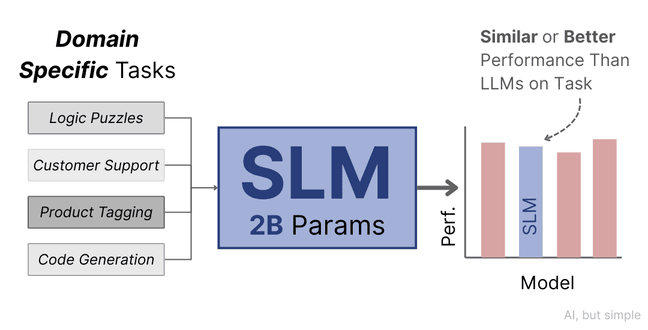

## **Importing Libraries**
To start, we'll install and import the necessary libraries. We use the HuggingFace Transformers library for loading models, PEFT for LoRA, and bitsandbytes for quantization (we'll import those later).

We’ll also use the standard deep learning libraries like PyTorch, and common utilities like time for benchmarking.

In Colab, you can install libraries with !pip (the code below includes this step, but skip it if already installed).

In [ ]:
# Skip the below line if libraries are already installed. Otherwise, uncomment the line to install.
# !pip install transformers torch accelerate peft bitsandbytes matplotlib seaborn

!pip install "auto-round>=0.5" # needed to load the quantized phi model

In [ ]:
import time
import math
import torch

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Current device: {device.upper()}")

## **Loading Models and Tokenizers**

We load our models from HuggingFace. For chat generation, we use a GPT-style language model. This type of model is called a causal model. We'll use:

* GPT-2 small (124M parameters),
* DistilGPT2 (82M parameters),
* TinyLlama-1.1B (1B parameters),

For summarization, we use sequence-to-sequence models:

* T5-small (~60M params) versatile for many text tasks.
* Optionally, DistilBART-CNN (sshleifer/distilbart-cnn-12-6, ~306M) for summarization benchmarks (faster than BART-large).

For reasoning tasks we'll specifically use Phi-2 (2.7B parameters).

Below, we load these models and tokenizers. We set them to evaluation mode and move them to the correct device.

In [ ]:
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer

# Define model identifiers
model_ids = {
    "gpt2": "gpt2",
    "distilgpt2": "distilgpt2",
    "tinyllama": "PY007/TinyLlama-1.1B-step-50K-105b",  # TinyLlama 1.1B
    "t5-small": "t5-small",
    # Optional larger summarizer for comparison:
    # "distilbart-cnn": "sshleifer/distilbart-cnn-12-6"
    "phi-2": "itachi023/phi-2-4-bit-quantized" # Phi-2 2.7B (Quantized)
}

# Load causal models
causal_models = {}
for name in ["gpt2", "distilgpt2", "tinyllama", "phi-2"]:
    print(f"Loading {name}...")
    model = AutoModelForCausalLM.from_pretrained(model_ids[name]).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_ids[name])
    # For GPT-2 variants, set padding side (needed to handle token inputs)
    tokenizer.padding_side = "left"
    tokenizer.truncation_side = "left"
    model.eval()
    causal_models[name] = (model, tokenizer)

# Load T5 (seq2seq model)
print("Loading T5-small for summarization...")
t5_model = AutoModelForSeq2SeqLM.from_pretrained(model_ids["t5-small"]).to(device)
t5_token = AutoTokenizer.from_pretrained(model_ids["t5-small"])
t5_model.eval()

Let's check the parameter counts of all of our models.

In [ ]:
for name, (model, _) in causal_models.items():
    params = sum(p.numel() for p in model.parameters())
    print(f"Model {name}: {params/1e6:.1f}M parameters")
print(f"T5-small: {sum(p.numel() for p in t5_model.parameters())/1e6:.1f}M parameters")

Note that the phi-2 quantized model shows only 260M parameters, but this is due to the paramaters being compressed from quantization.

## **Chatbot Example**
 Let’s try a simple chatbot-style prompt with each model. We use a short prompt and generate a response. For causal models, we can use the generate method directly. We use the pipeline for convenience, which handles tokenization along with generation.

In [ ]:
from transformers import pipeline, set_seed

prompt = "What is your favorite food?"
max_len = 100  # max new tokens to generate

print("Chatbot-style responses:")
for name, (model, tokenizer) in causal_models.items():
    print(f"\n[{name}] Prompt: {prompt}")

    # Using pipeline for convenience
    generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0 if device=='cuda' else -1)

    set_seed(42)  # for reproducibility
    outputs = generator(prompt, max_new_tokens=max_len, do_sample=True, top_p=0.95) # stochastic generation (do_sample=True), the outputs will vary
    for i, out in enumerate(outputs):
        text = out["generated_text"]
        print(f"  Response: {text[len(prompt):]}")

## **Text Summarization Example**
For the summarzation example, we'll use a paragraph of dummy news text and let a summarization model shorten it.

Here, we use our sequence-to-sequence T5-small model as the summarization model. We'll also continue using the pipeline for convenience.

In [ ]:
article = (
    "The city's public transportation department announced new measures today. "
    "According to officials, bus schedules will be increased by 20% during peak hours "
    "to reduce overcrowding. The mayor stated that this change comes in response to "
    "surveys indicating commuter dissatisfaction with current wait times. Environmental "
    "groups have praised the move, noting that improved transit could lead to reduced traffic and emissions."
)

# Summarize using T5-small
summarizer = pipeline("summarization", model=t5_model, tokenizer=t5_token, device=0 if device=='cuda' else -1)
summary = summarizer(article, max_length=40, min_length=10, do_sample=False)
print("T5-small summary:", summary[0]['summary_text'])

## **Reasoning Example**
We can also test how these models handle simple reasoning. For example: "*Five people are in a 100m race. Person A finished before person B, but behind person C. Person D finished before person E, but behind person B. What was the finishing order?*"

We keep the prompt simple (zero-shot), but we can use multi-shot prompting to try to improve the result.

In [ ]:
question = "Five people are in a 100m race. Person A finished before person B, but behind person C. Person D finished before person E, but behind person B. What was the finishing order?"
print("Reasoning prompt:", question)

model, tokenizer = causal_models["phi-2"]

# Setup generation pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if device == 'cuda' else -1
)

set_seed(123)

# Generate response
output = generator(question, do_sample=False)[0]['generated_text']

# Strip the prompt from the output
answer = output[len(question):].strip()
print(f"\n[{"phi-2"}] Answer:", answer)

## Benchmarking

To compare speed and output length, we benchmark inference latency and average response length for each model.

To do this, we use Python’s time library and generate a number of tokens. We then visualize results with matplotlib. You are encouraged to run this loop multiple times to see the average.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

models_to_test = ["gpt2", "distilgpt2", "t5-small", "tinyllama", "phi-2"]
latencies = []

prompt = "Generate a story of a dog and a cat."

for name in models_to_test:
    model, tokenizer = (causal_models[name] if name in causal_models
                        else (t5_model, t5_token))
    # Prepare input tokens
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # Warm-up (usually slower and not representative of actual time)
    _ = model.generate(**inputs, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
    # Time multiple runs
    runs = 3
    total_time = 0.0
    total_len = 0
    for _ in range(runs):
        start = time.time()
        outputs = model.generate(**inputs, max_new_tokens = 100, pad_token_id=tokenizer.eos_token_id)
        end = time.time()
        total_time += (end - start)
    avg_time = total_time / runs
    latencies.append(avg_time)
    print(f"{name}: Avg latency = {avg_time:.3f}s")

We plot the results below using bar charts.

In [ ]:
sns.set_style("whitegrid")
# Inference Latency
plt.figure(figsize=(6,4))
sns.barplot(x=models_to_test, y=latencies, palette="Set2")
plt.ylabel("Avg Latency (s)")
plt.title("Inference Latency per Model")
plt.show()

The charts would show that larger models are slower per token than the tiny models. This is especially true for phi-2, since it is also a reasoning model. The output lengths are all set to 100 new tokens, so lengths should be similar.